# Fine-tuning InceptionV3 for flowers classification

In this task you will fine-tune InceptionV3 architecture for flowers classification task.

InceptionV3 architecture (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html):
<img src="images/inceptionv3.png" style="width:70%">

Flowers classification dataset (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) consists of 102 flower categories commonly occurring in the United Kingdom. Each class contains between 40 and 258 images:
<img src="images/flowers.jpg" style="width:70%">

# Import stuff

In [1]:
# use preloaded keras datasets and models
! mkdir -p ~/.keras/datasets
! mkdir -p ~/.keras/models
! ln -s $(realpath ../readonly/keras/datasets/*) ~/.keras/datasets/
! ln -s $(realpath ../readonly/keras/models/*) ~/.keras/models/

命令语法不正确。
命令语法不正确。
'ln' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
'ln' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [2]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import cv2  # for image processing
from sklearn.model_selection import train_test_split
import scipy.io
import os
import grading
import tarfile
import tqdm

Using TensorFlow backend.


1.3.0
2.0.8


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [3]:
grader = grading.Grader(assignment_key="2v-uxpD7EeeMxQ6FWsz5LA", 
                        all_parts=["wuwwC", "a4FK1", "qRsZ1"])

In [4]:
# token expires every 30 min
COURSERA_TOKEN = '8UBeTBC8cz1dJ90P' ### YOUR TOKEN HERE
COURSERA_EMAIL ='wsdgh@qq.com' ### YOUR EMAIL HERE

# Load dataset

Dataset was downloaded for you, it takes 12 min and 400mb.
Relevant links (just in case):
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

In [5]:
# we downloaded them for you, just link them here
! ln -s $(realpath ../readonly/week3/*) .

'ln' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


# Prepare images for model

In [6]:
# we will crop and resize input images to IMG_SIZE x IMG_SIZE
IMG_SIZE = 250

In [7]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

We will take a center crop from each image like this:
<img src="images/center_crop.jpg" style="width:50%">

In [8]:
def image_center_crop(img):
    """
    Makes a square center crop of an img, which is a [h, w, 3] numpy array.
    Returns [min(h, w), min(h, w), 3] output with same width and height.
    For cropping use numpy slicing.
    """
    ### YOUR CODE HERE
    h = img.shape[0]
    w = img.shape[1]
    l = min(h, w)
    h_side = (h - l) // 2
    w_side = (w - l) // 2
    cropped_img = img[h_side:h_side+l, w_side:w_side+l, :]
    
    return cropped_img

In [9]:
def prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=True):
    img = decode_image_from_raw_bytes(raw_bytes)  # decode image raw bytes to matrix
    img = image_center_crop(img)  # take squared center crop
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # resize for our model
    if normalize_for_model:
        img = img.astype("float32")  # prepare for normalization
        img = keras.applications.inception_v3.preprocess_input(img)  # normalize for model
    return img

In [10]:
# reads bytes directly from tar by filename (slow, but ok for testing, takes ~6 sec)
def read_raw_from_tar(tar_fn, fn):
    with tarfile.open(tar_fn) as f:
        m = f.getmember(fn)
        return f.extractfile(m).read()

(500, 591, 3)


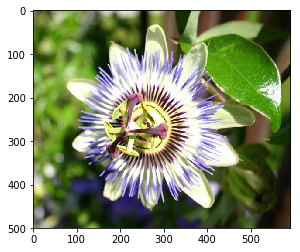

(250, 250, 3)


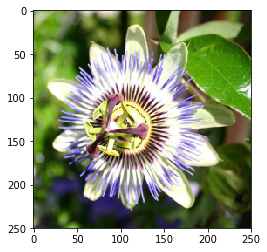

In [11]:
# test cropping
raw_bytes = read_raw_from_tar(r"E:\MLDL_work\hse-aml\1_intro-to-dl\readonly\week3\102flowers.tgz", "jpg/image_00001.jpg")

img = decode_image_from_raw_bytes(raw_bytes)
print(img.shape)
plt.imshow(img)
plt.show()

img = prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=False)
print(img.shape)
plt.imshow(img)
plt.show()

In [12]:
## GRADED PART, DO NOT CHANGE!
# Test image preparation for model
prepared_img = prepare_raw_bytes_for_model(read_raw_from_tar(r"E:\MLDL_work\hse-aml\1_intro-to-dl\readonly\week3\102flowers.tgz", "jpg/image_00001.jpg"))
grader.set_answer("qRsZ1", list(prepared_img.shape) + [np.mean(prepared_img), np.std(prepared_img)])

In [13]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists.


# Prepare for training

In [14]:
# read all filenames and labels for them

# read filenames firectly from tar
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

all_files = sorted(get_all_filenames(r"E:\MLDL_work\hse-aml\1_intro-to-dl\readonly\week3\102flowers.tgz"))  # list all files in tar sorted by name
all_labels = scipy.io.loadmat(r'E:\MLDL_work\hse-aml\1_intro-to-dl\readonly\week3\imagelabels.mat')['labels'][0] - 1  # read class labels (0, 1, 2, ...)
# all_files and all_labels are aligned now
N_CLASSES = len(np.unique(all_labels))
print(N_CLASSES)

102


In [15]:
# split into train/test
tr_files, te_files, tr_labels, te_labels = \
    train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

In [16]:
# will yield raw image bytes from tar with corresponding label
def raw_generator_with_label_from_tar(tar_fn, files, labels):
    label_by_fn = dict(zip(files, labels))
    with tarfile.open(tar_fn) as f:
        for m in f.getmembers():  # listing members is slow, but then it's fast!
            if m.name in label_by_fn:
                yield f.extractfile(m).read(), label_by_fn[m.name]

In [17]:
# batch generator
BATCH_SIZE = 32

def batch_generator(items, batch_size):
    """
    Implement batch generator that yields items by batches of size batch_size.
    Remember about the last batch that can be smaller than batch_size!
    """
    
    ### YOUR CODE HERE
    items = list(items)
    n_batch =len(items) // batch_size
    for i in range(n_batch):
        yield items[i*batch_size: (i+1)*batch_size]
    yield items[n_batch*batch_size:]

In [18]:
## GRADED PART, DO NOT CHANGE!
# Test batch generator
grader.set_answer("a4FK1", list(map(lambda x: len(x), batch_generator(range(10), 3))))

In [19]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists.


In [30]:
def train_generator(files, labels):
    while True:  # so that Keras can loop through this as long as it wants
        for batch in batch_generator(raw_generator_with_label_from_tar(
                r"E:\MLDL_work\hse-aml\1_intro-to-dl\readonly\week3\102flowers.tgz", files, labels), BATCH_SIZE):
            # prepare batch images
            batch_imgs = []
            batch_targets = []
            for raw, label in batch:
                img = prepare_raw_bytes_for_model(raw)
                batch_imgs.append(img)
                batch_targets.append(label)
            # stack images into 4D tensor [batch_size, img_size, img_size, 3]
            batch_imgs = np.stack(batch_imgs, axis=0)
            # convert targets into 2D tensor [batch_size, num_classes]
            batch_targets = keras.utils.np_utils.to_categorical(batch_targets, N_CLASSES)
            yield batch_imgs, batch_targets

In [31]:
# test training generator
for _ in train_generator(tr_files, tr_labels):
    print(_[0].shape, _[1].shape)
    plt.imshow(_[0][0])
    break

(32, 250, 250, 3) (32, 102)


ValueError: Floating point image RGB values must be in the 0..1 range.

# Training

You cannot train such a huge architecture from scratch with such a small dataset.

But using fine-tuning of last layers of pre-trained network you can get a pretty good classifier very quickly.

In [32]:
# remember to clear session if you start building graph from scratch!
K.clear_session()
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)

In [33]:
def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    model = keras.applications.InceptionV3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                          weights='imagenet' if use_imagenet else None)
    # add global pooling just like in InceptionV3
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    # add new dense layer for our labels
    #new_output = keras.layers.Dropout(0.2)(new_output)
    #new_output = keras.layers.Dense(10 * N_CLASSES, activation='relu')(new_output)
    new_output = keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [34]:
model = inception()

In [35]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 250, 250, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 124, 124, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 124, 124, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 124, 124, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

activation_12 (Activation)       (None, 28, 28, 32)    0           batch_normalization_12[0][0]     
____________________________________________________________________________________________________
mixed0 (Concatenate)             (None, 28, 28, 256)   0           activation_6[0][0]               
                                                                   activation_8[0][0]               
                                                                   activation_11[0][0]              
                                                                   activation_12[0][0]              
____________________________________________________________________________________________________
conv2d_16 (Conv2D)               (None, 28, 28, 64)    16384       mixed0[0][0]                     
____________________________________________________________________________________________________
batch_normalization_16 (BatchNor (None, 28, 28, 64)    192         conv2d_16[0][0]         

____________________________________________________________________________________________________
conv2d_26 (Conv2D)               (None, 28, 28, 64)    18432       average_pooling2d_3[0][0]        
____________________________________________________________________________________________________
batch_normalization_20 (BatchNor (None, 28, 28, 64)    192         conv2d_20[0][0]                  
____________________________________________________________________________________________________
batch_normalization_22 (BatchNor (None, 28, 28, 64)    192         conv2d_22[0][0]                  
____________________________________________________________________________________________________
batch_normalization_25 (BatchNor (None, 28, 28, 96)    288         conv2d_25[0][0]                  
____________________________________________________________________________________________________
batch_normalization_26 (BatchNor (None, 28, 28, 64)    192         conv2d_26[0][0]         

____________________________________________________________________________________________________
batch_normalization_33 (BatchNor (None, 13, 13, 128)   384         conv2d_33[0][0]                  
____________________________________________________________________________________________________
batch_normalization_38 (BatchNor (None, 13, 13, 128)   384         conv2d_38[0][0]                  
____________________________________________________________________________________________________
activation_33 (Activation)       (None, 13, 13, 128)   0           batch_normalization_33[0][0]     
____________________________________________________________________________________________________
activation_38 (Activation)       (None, 13, 13, 128)   0           batch_normalization_38[0][0]     
____________________________________________________________________________________________________
average_pooling2d_4 (AveragePool (None, 13, 13, 768)   0           mixed3[0][0]            

____________________________________________________________________________________________________
conv2d_49 (Conv2D)               (None, 13, 13, 192)   215040      activation_48[0][0]              
____________________________________________________________________________________________________
conv2d_50 (Conv2D)               (None, 13, 13, 192)   147456      average_pooling2d_5[0][0]        
____________________________________________________________________________________________________
batch_normalization_41 (BatchNor (None, 13, 13, 192)   576         conv2d_41[0][0]                  
____________________________________________________________________________________________________
batch_normalization_44 (BatchNor (None, 13, 13, 192)   576         conv2d_44[0][0]                  
____________________________________________________________________________________________________
batch_normalization_49 (BatchNor (None, 13, 13, 192)   576         conv2d_49[0][0]         

____________________________________________________________________________________________________
activation_54 (Activation)       (None, 13, 13, 192)   0           batch_normalization_54[0][0]     
____________________________________________________________________________________________________
activation_59 (Activation)       (None, 13, 13, 192)   0           batch_normalization_59[0][0]     
____________________________________________________________________________________________________
activation_60 (Activation)       (None, 13, 13, 192)   0           batch_normalization_60[0][0]     
____________________________________________________________________________________________________
mixed6 (Concatenate)             (None, 13, 13, 768)   0           activation_51[0][0]              
                                                                   activation_54[0][0]              
                                                                   activation_59[0][0]     

batch_normalization_73 (BatchNor (None, 13, 13, 192)   576         conv2d_73[0][0]                  
____________________________________________________________________________________________________
activation_73 (Activation)       (None, 13, 13, 192)   0           batch_normalization_73[0][0]     
____________________________________________________________________________________________________
conv2d_74 (Conv2D)               (None, 13, 13, 192)   258048      activation_73[0][0]              
____________________________________________________________________________________________________
batch_normalization_74 (BatchNor (None, 13, 13, 192)   576         conv2d_74[0][0]                  
____________________________________________________________________________________________________
activation_74 (Activation)       (None, 13, 13, 192)   0           batch_normalization_74[0][0]     
___________________________________________________________________________________________

____________________________________________________________________________________________________
activation_79 (Activation)       (None, 6, 6, 384)     0           batch_normalization_79[0][0]     
____________________________________________________________________________________________________
activation_80 (Activation)       (None, 6, 6, 384)     0           batch_normalization_80[0][0]     
____________________________________________________________________________________________________
activation_83 (Activation)       (None, 6, 6, 384)     0           batch_normalization_83[0][0]     
____________________________________________________________________________________________________
activation_84 (Activation)       (None, 6, 6, 384)     0           batch_normalization_84[0][0]     
____________________________________________________________________________________________________
batch_normalization_85 (BatchNor (None, 6, 6, 192)     576         conv2d_85[0][0]         

                                                                   activation_89[0][0]              
____________________________________________________________________________________________________
concatenate_2 (Concatenate)      (None, 6, 6, 768)     0           activation_92[0][0]              
                                                                   activation_93[0][0]              
____________________________________________________________________________________________________
activation_94 (Activation)       (None, 6, 6, 192)     0           batch_normalization_94[0][0]     
____________________________________________________________________________________________________
mixed10 (Concatenate)            (None, 6, 6, 2048)    0           activation_86[0][0]              
                                                                   mixed9_1[0][0]                   
                                                                   concatenate_2[0][0]     

In [36]:
# how many layers our model has
print(len(model.layers))

313


In [37]:
# set all layers trainable by default and prepare batch norm for fine-tuning
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm 
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.8
    
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
    layer.trainable = False

In [38]:
# compile new model
model.compile(
    loss='categorical_crossentropy',  # we train 102-way classification
    optimizer=keras.optimizers.adamax(lr=1e-2),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

In [39]:
# fine tune for 2 epochs
model.fit_generator(
    train_generator(tr_files, tr_labels), 
    steps_per_epoch=len(tr_files) // BATCH_SIZE, 
    epochs=2,
    validation_data=train_generator(te_files, te_labels), 
    validation_steps=len(te_files) // BATCH_SIZE // 2,
)

Epoch 1/2
204/204 [==============================] - ETA: 2119s - loss: 4.7618 - acc: 0.0000e+ - ETA: 1227s - loss: 6.4553 - acc: 0.0469   - ETA: 927s - loss: 6.5013 - acc: 0.0833 - ETA: 777s - loss: 6.0068 - acc: 0.125 - ETA: 686s - loss: 5.7105 - acc: 0.137 - ETA: 625s - loss: 5.4831 - acc: 0.151 - ETA: 581s - loss: 5.3747 - acc: 0.151 - ETA: 547s - loss: 5.1914 - acc: 0.164 - ETA: 521s - loss: 5.0955 - acc: 0.163 - ETA: 499s - loss: 4.9251 - acc: 0.184 - ETA: 482s - loss: 4.8082 - acc: 0.198 - ETA: 466s - loss: 4.6919 - acc: 0.208 - ETA: 453s - loss: 4.6197 - acc: 0.213 - ETA: 442s - loss: 4.5400 - acc: 0.225 - ETA: 432s - loss: 4.4402 - acc: 0.239 - ETA: 423s - loss: 4.3928 - acc: 0.238 - ETA: 414s - loss: 4.3114 - acc: 0.248 - ETA: 407s - loss: 4.2351 - acc: 0.260 - ETA: 400s - loss: 4.2168 - acc: 0.256 - ETA: 393s - loss: 4.1471 - acc: 0.259 - ETA: 388s - loss: 4.0800 - acc: 0.261 - ETA: 382s - loss: 4.0077 - acc: 0.275 - ETA: 377s - loss: 3.9514 - acc: 0.278 - ETA: 372s - loss: 

204/204 [==============================] - ETA: 1339s - loss: 0.4300 - acc: 0.82 - ETA: 838s - loss: 0.2282 - acc: 0.9130 - ETA: 668s - loss: 0.1772 - acc: 0.931 - ETA: 583s - loss: 0.1587 - acc: 0.948 - ETA: 531s - loss: 0.1497 - acc: 0.952 - ETA: 496s - loss: 0.1694 - acc: 0.945 - ETA: 470s - loss: 0.1699 - acc: 0.943 - ETA: 450s - loss: 0.2013 - acc: 0.931 - ETA: 435s - loss: 0.1936 - acc: 0.935 - ETA: 422s - loss: 0.1964 - acc: 0.935 - ETA: 411s - loss: 0.1964 - acc: 0.935 - ETA: 402s - loss: 0.1872 - acc: 0.938 - ETA: 393s - loss: 0.1899 - acc: 0.936 - ETA: 386s - loss: 0.1895 - acc: 0.938 - ETA: 380s - loss: 0.1906 - acc: 0.938 - ETA: 374s - loss: 0.1857 - acc: 0.940 - ETA: 369s - loss: 0.2071 - acc: 0.934 - ETA: 364s - loss: 0.2231 - acc: 0.927 - ETA: 359s - loss: 0.2248 - acc: 0.928 - ETA: 355s - loss: 0.2305 - acc: 0.928 - ETA: 351s - loss: 0.2304 - acc: 0.929 - ETA: 347s - loss: 0.2254 - acc: 0.931 - ETA: 343s - loss: 0.2216 - acc: 0.932 - ETA: 340s - loss: 0.2175 - acc: 0.93

In [40]:
# save weights to file
model.save_weights("weights.h5")

In [41]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

In [42]:
## GRADED PART, DO NOT CHANGE!
# Accuracy on validation set
test_accuracy = model.evaluate_generator(
    train_generator(te_files, te_labels), 
    len(te_files) // BATCH_SIZE // 2
)[1]
grader.set_answer("wuwwC", test_accuracy)
print(test_accuracy)

0.93875


In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

That's it! Congratulations!

What you've done:
- prepared images for the model
- implemented your own batch generator
- fine-tuned the pre-trained model